In [1]:
import matplotlib.pyplot as plt
from matplotlib import font_manager
# 设置字体路径
font_path = '/System/Library/Fonts/STHeiti Medium.ttc'

# 加载字体
my_font = font_manager.FontProperties(fname=font_path)

# 设置为默认字体
plt.rcParams['font.family'] = my_font.get_name()
plt.rcParams['axes.unicode_minus'] = False  # 正确显示负号

In [2]:
import tushare as ts  # 股票基本数据相关库
import numpy as np  # 科学计算相关库
import pandas as pd  # 科学计算相关库  
import talib  # 股票衍生变量数据相关库
import matplotlib.pyplot as plt  # 引入绘图相关库，可视化
from sklearn.ensemble import RandomForestClassifier  # 引入分类决策树模型
from sklearn.metrics import accuracy_score  # 引入准确度评分函数
import warnings
warnings.filterwarnings("ignore") # 忽略警告信息，警告非报错，不影响代码执行

In [3]:
# 1.股票基本数据获取
df = ts.get_k_data('000002',start='2015-01-01',end='2019-12-31')
df = df.set_index('date')  # 设置日期为索引

# 2.简单衍生变量构造
df['close-open'] = (df['close'] - df['open'])/df['open']
df['high-low'] = (df['high'] - df['low'])/df['low']

df['pre_close'] = df['close'].shift(1)  # 该列所有往下移一行形成昨日收盘价
df['price_change'] = df['close']-df['pre_close']
df['p_change'] = (df['close']-df['pre_close'])/df['pre_close']*100

# 3.移动平均线相关数据构造
df['MA5'] = df['close'].rolling(5).mean()
df['MA10'] = df['close'].rolling(10).mean()
df.dropna(inplace=True)  # 删除空值

# 4.通过Ta_lib库构造衍生变量
df['RSI'] = talib.RSI(df['close'], timeperiod=12)  # 相对强弱指标
df['MOM'] = talib.MOM(df['close'], timeperiod=5)  # 动量指标
df['EMA12'] = talib.EMA(df['close'], timeperiod=12)  # 12日指数移动平均线
df['EMA26'] = talib.EMA(df['close'], timeperiod=26)  # 26日指数移动平均线
df['MACD'], df['MACDsignal'], df['MACDhist'] = talib.MACD(df['close'], fastperiod=12, slowperiod=26, signalperiod=9)  # MACD值
df.dropna(inplace=True)  # 删除空值

本接口即将停止更新，请尽快使用Pro版接口：https://tushare.pro/document/2


AttributeError: 'DataFrame' object has no attribute 'append'

库太老了 我使用其他数据获取库
用其他更现代的库来获取股票数据

akshare

pip install akshare

In [3]:
import akshare as ak
df = ak.stock_zh_a_hist(symbol="000002", period="daily", start_date="20150101", end_date="20191231", adjust="")
df = df.set_index('日期')


In [4]:
df.head()

,股票代码,开盘,收盘,最高,最低,成交量,成交额,振幅,涨跌幅,涨跌额,换手率
日期,,,,,,,,,,,
2015-01-05,000002,14.39,14.91,15.29,14.22,6560836,9.700712e+09,7.70,7.27,1.01,6.76
2015-01-06,000002,14.60,14.36,14.99,14.05,3346347,4.839616e+09,6.30,-3.69,-0.55,3.45
2015-01-07,000002,14.26,14.23,14.50,14.00,2642051,3.772151e+09,3.48,-0.91,-0.13,2.72
2015-01-08,000002,14.32,13.59,14.37,13.46,2639394,3.629554e+09,6.39,-4.50,-0.64,2.72
2015-01-09,000002,13.54,13.45,14.22,13.29,3294584,4.521978e+09,6.84,-1.03,-0.14,3.39


In [ ]:
import akshare as ak
import pandas as pd

df = ak.stock_zh_a_hist(symbol="000002", period="daily", start_date="20150101", end_date="20150131", adjust="qfq")

df = df[["日期", "开盘", "最高", "最低", "收盘", "成交量"]].copy()
df.rename(columns={"日期":"Date", "开盘":"Open", "最高":"High", "最低":"Low", "收盘":"Close", "成交量":"Volume"}, inplace=True)

df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)

In [ ]:
import plotly.graph_objects as go

data = df.loc["2015-01-01":"2015-01-31"]

fig = go.Figure(data=[go.Candlestick(
    x=data.index,
    open=data["Open"],
    high=data["High"],
    low=data["Low"],
    close=data["Close"],
    increasing_line_color="red",
    decreasing_line_color="green"
)])

fig.update_layout(
    title="000002 万科A K线图 (2015-01)",
    xaxis_title="日期",
    yaxis_title="价格",
    xaxis_rangeslider_visible=False
)

fig.show()

# 随机森林

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

df = ak.stock_zh_a_hist(symbol="000002", period="daily", start_date="20150101", end_date="20150131", adjust="qfq")

df["label"] = (df["收盘"].shift(-1) > df["收盘"]).astype(int)  # 次日涨=1，跌=0

X = df[["开盘", "最高", "最低", "收盘", "成交量", "成交额", "振幅", "涨跌幅", "换手率"]]
y = df["label"]

X = X[:-1]
y = y[:-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print("准确率:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

准确率: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4



In [6]:
feature_importances = pd.Series(rf.feature_importances_, index=X.columns)
feature_importances = feature_importances.sort_values(ascending=False)
print(feature_importances)

开盘     0.377245
最高     0.251593
最低     0.151072
收盘     0.121310
涨跌幅    0.044400
振幅     0.019585
成交量    0.017256
换手率    0.009458
成交额    0.008080
dtype: float64


# 决策树

In [7]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(random_state=42)
dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[2 0]
 [1 1]]
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      0.50      0.67         2

    accuracy                           0.75         4
   macro avg       0.83      0.75      0.73         4
weighted avg       0.83      0.75      0.73         4



In [8]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(dtc, X_train, y_train, cv=5, scoring='accuracy')

print("各折准确率：", scores)
print("平均准确率：%.4f (+/- %.4f)" % (scores.mean(), scores.std() * 2))

各折准确率： [1.         1.         0.66666667 0.66666667 1.        ]
平均准确率：0.8667 (+/- 0.3266)


# GBDT

In [9]:
from sklearn.ensemble import GradientBoostingClassifier

GBDT = GradientBoostingClassifier(random_state=42)
GBDT.fit(X_train, y_train)
y_pred = GBDT.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[2 0]
 [1 1]]
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      0.50      0.67         2

    accuracy                           0.75         4
   macro avg       0.83      0.75      0.73         4
weighted avg       0.83      0.75      0.73         4



In [10]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(GBDT, X_train, y_train, cv=5, scoring='accuracy')

print("各折准确率：", scores)
print("平均准确率：%.4f (+/- %.4f)" % (scores.mean(), scores.std() * 2))

各折准确率： [1.         1.         0.66666667 0.66666667 1.        ]
平均准确率：0.8667 (+/- 0.3266)


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.1, 0.05, 0.01],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='f1_macro',  # 也可以换成 'accuracy', 'roc_auc'
    n_jobs=-1
)

grid.fit(X_train, y_train)
print("Best Params:", grid.best_params_)
print("Best Score:", grid.best_score_)

Best Params: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Score: 0.8666666666666666


# 朴素贝叶斯

In [11]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train, y_train)

y_pred_nb = nb.predict(X_test)
y_pred_proba = nb.predict_proba(X_test)[:, 1]  # 离职概率（正类概率）

print("混淆矩阵：")
print(confusion_matrix(y_test, y_pred_nb))
print("\n分类报告：")
print(classification_report(y_test, y_pred_nb))

print("\n前5个样本的离职概率：", y_pred_proba[:5])

混淆矩阵：
[[0 2]
 [1 1]]

分类报告：
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.33      0.50      0.40         2

    accuracy                           0.25         4
   macro avg       0.17      0.25      0.20         4
weighted avg       0.17      0.25      0.20         4


前5个样本的离职概率： [0.70530424 0.68737148 0.52965473 0.4826388 ]


In [12]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(nb, X_train, y_train, cv=5, scoring='accuracy')

print("各折准确率：", scores)
print("平均准确率：%.4f (+/- %.4f)" % (scores.mean(), scores.std() * 2))

各折准确率： [0.33333333 0.         0.33333333 0.33333333 0.33333333]
平均准确率：0.2667 (+/- 0.2667)


可以看到 贝叶斯的结果非常不好 这是因为 贝叶斯模型假设特征之间是独立的 而在股票市场中 特征之间往往存在很强的相关性 所以贝叶斯模型的效果不好

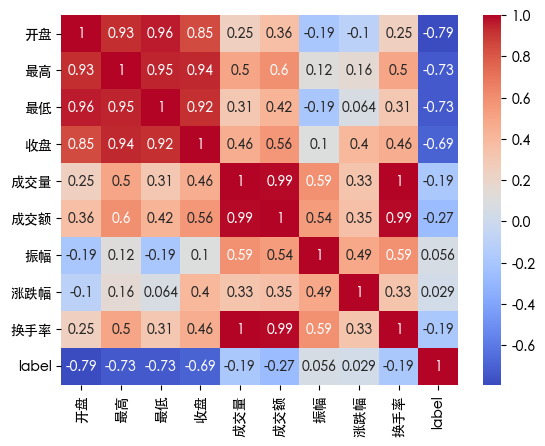

In [14]:
import seaborn as sns
correlation_matrix = pd.concat([X_train, y_train], axis=1).corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

# LDA

In [16]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

LDA = LinearDiscriminantAnalysis()
LDA.fit(X_train, y_train)
y_pred_lda = LDA.predict(X_test)
y_pred_proba_lda = LDA.predict_proba(X_test)[:, 1]

print("混淆矩阵：")
print(confusion_matrix(y_test, y_pred_lda))
print("\n分类报告：")
print(classification_report(y_test, y_pred_lda))

混淆矩阵：
[[2 0]
 [0 2]]

分类报告：
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4



In [15]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(LDA, X_train, y_train, cv=5, scoring='accuracy')

print("各折准确率：", scores)
print("平均准确率：%.4f (+/- %.4f)" % (scores.mean(), scores.std() * 2))

各折准确率： [0.66666667 0.66666667 0.66666667 0.66666667 0.33333333]
平均准确率：0.6000 (+/- 0.2667)


In [20]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

tscv = TimeSeriesSplit(n_splits=5)
scores = cross_val_score(LDA, X_train, y_train, cv=tscv, scoring='accuracy')
print("各折准确率：", scores)
print("平均准确率：%.4f (+/- %.4f)" % (scores.mean(), scores.std() * 2))

各折准确率： [0.5 0.5 0.5 0.5 0.5]
平均准确率：0.5000 (+/- 0.0000)
